# NEURON modeling exercise #3

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## More on Sections

In case that you want to build an artificial neuron model, instead of using the experimentally measured morphology, you can build a multi-compartmental model by constructing Sections and connecting them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui

# we build a three-compartment model
soma = h.Section(name='soma')
dends = [h.Section(name=f'dend{i+1}') for i in range(2)]

In [2]:
print(dends)
dends[0].psection()

[dend1, dend2]


{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'dend1',
 'hoc_internal_name': '__nrnsec_0x7fcec01a0060',
 'cell': None}

Let's adjust their size first.

In [3]:
soma.L = 4
soma.diam = 8

for d in dends:
    d.L = 600
    d.diam = 5
    d.nseg = 1 # isopotential sections

Then, we connect the soma and dend(rite)s electrically.

In [4]:
for d in dends:
    d.connect(soma(1), 0)

In [5]:
h.topology()


|-|       soma(0-1)
   `|       dend1(0-1)
   `|       dend2(0-1)



1.0

Let's include a passive mechanism to the soma and dendrites.

In [6]:
for s in h.allsec():
    s.insert('pas')
    s.g_pas = 0.5e-4 # 0.0005 S/cm2

h.v_init = soma.e_pas # we set the initial voltage to the reversal potential of the passive membrane


Let's put a current clamp on one of the dendrites.

In [7]:
ic = h.IClamp(dends[0](0.5))
ic.amp = 0.2 # 200 pA
ic.delay = 10
ic.dur = 150

In [13]:
def record_and_run(tstop=250, dt=0.1):
    vrec = h.Vector()
    trec = h.Vector()
    
    vrec.record(dends[0](0.5)._ref_v, dt)
    trec.record(h._ref_t, dt)
    
    h.tstop = tstop
    h.init()
    h.run()

    return vrec.c(), trec.c()
    
def run_and_plot(tstop=250, ax=None):
    v, t = record_and_run(tstop=tstop)
    
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(t, v)

    

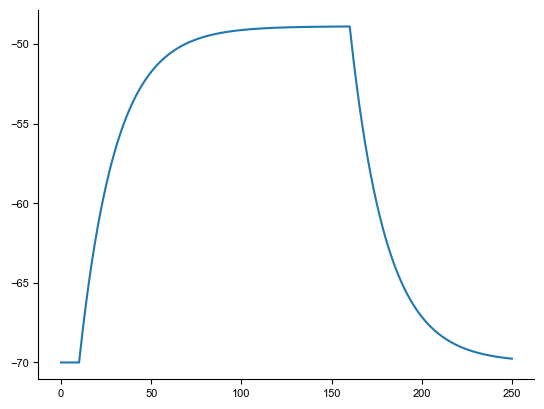

In [9]:
run_and_plot()

Let's change the coupling of the dendrite and soma. We first measure what is the resistance between the soma and the first dendrite.

In [10]:
# https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html?highlight=ri#ri
# Return the resistance (in megohms) between the center of the segment section(x) and its parent segment.

dends[0](0.5).ri()

5.408721586034971

We can change the result by changing the axial resistance of the dendrite.

Now the resistance is 540.8722 MΩ.


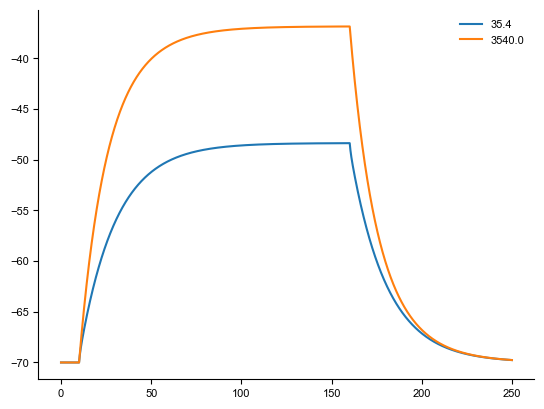

In [15]:
dends[0].Ra = dends[1].Ra

_, ax = plt.subplots()

v, t = record_and_run()
ax.plot(t, v, label=f'{dends[0].Ra}')

dends[0].Ra = dends[1].Ra*100
print(f'Now the resistance is {dends[0](0.5).ri():.4f} MΩ.')

v, t = record_and_run()
ax.plot(t, v, label=f'{dends[0].Ra}')
_ = plt.legend()

## Active mechanisms and NMODL

* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl

### How to compile mechanisms:
1. `nrnivmodl mod.files` in Terminal (or `cd mod.files; nrnivmodl`), OR
2. Use `mknrndll.app` (or equivalent apps in Windows or Linux).

In [16]:
%%bash
nrnivmodl mod.files

/usr/bin/xcrun
/Users/shhong/Dropbox (OIST)/CNS_course/2023/a310_cns_2023/class_2
-n Mod files:
-n  "mod.files/mod.files/CaT.mod"
-n  "mod.files/mod.files/ConnorStevens.mod"
-n  "mod.files/mod.files/HH2.mod"
-n  "mod.files/mod.files/ca.mod"
-n  "mod.files/mod.files/caL3d.mod"
-n  "mod.files/mod.files/cad.mod"
-n  "mod.files/mod.files/ccstdpsyn.mod"
-n  "mod.files/mod.files/exp2synNMDA.mod"
-n  "mod.files/mod.files/h.mod"
-n  "mod.files/mod.files/kca.mod"
-n  "mod.files/mod.files/kir.mod"
-n  "mod.files/mod.files/km.mod"
-n  "mod.files/mod.files/kv.mod"
-n  "mod.files/mod.files/mease.mod"
-n  "mod.files/mod.files/na.mod"
-n  "mod.files/mod.files/netstim2.mod"
-n  "mod.files/mod.files/wb.mod"


Creating 'x86_64' directory for .o files.

 -> NMODL ../mod.files/CaT.mod
 -> NMODL ../mod.files/HH2.mod
 -> NMODL ../mod.files/ConnorStevens.mod
 -> Compiling mod_func.cpp


/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating HH2.mod into HH2.c
Translating ConnorStevens.mod into ConnorStevens.c
Translating CaT.mod into CaT.c
Notice: VERBATIM blocks are not thread safe
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Notice: This mechanism cannot be used with CVODE


Thread Safe


 -> NMODL ../mod.files/ca.mod
 -> NMODL ../mod.files/caL3d.mod
 -> NMODL ../mod.files/cad.mod


/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating ca.mod into ca.c
Translating cad.mod into cad.c
Translating caL3d.mod into caL3d.c
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
NEURON's CVode method ignores conservation
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Thread Safe


 -> NMODL ../mod.files/ccstdpsyn.mod
 -> NMODL ../mod.files/exp2synNMDA.mod
 -> NMODL ../mod.files/h.mod


/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating ccstdpsyn.mod into ccstdpsyn.c
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating h.mod into h.c
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating exp2synNMDA.mod into exp2synNMDA.c
Notice: Assignment to the GLOBAL variable, "linf", is not thread safe
Notice: Assignment to the GLOBAL variable, "taul", is not thread safe
Thread Safe
Thread Safe


 -> NMODL ../mod.files/kir.mod
 -> NMODL ../mod.files/kca.mod
 -> NMODL ../mod.files/km.mod


/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating kir.mod into kir.c
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating kca.mod into kca.c
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating km.mod into km.c
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Thread Safe


 -> NMODL ../mod.files/kv.mod
 -> NMODL ../mod.files/mease.mod
 -> NMODL ../mod.files/na.mod


/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating kv.mod into kv.c
Translating mease.mod into mease.c
Translating na.mod into na.c
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Thread Safe


 -> NMODL ../mod.files/netstim2.mod
 -> NMODL ../mod.files/wb.mod


/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nocmodl: Warning several input files specified on command line but only one will be processed
Translating netstim2.mod into netstim2.c
Translating wb.mod into wb.c
 Multistep integrators (such as Runge) may not work correctly.
Thread Safe


Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator


Thread Safe


 -> Compiling CaT.c
 -> Compiling ConnorStevens.c
 -> Compiling HH2.c
 -> Compiling ca.c


clang: error: no such file or directory: 'CaT.c'
clang: error: no input files
clang: error: no such file or directory: 'HH2.c'
clang: error: no input files
clang: error: no such file or directory: 'ConnorStevens.c'
clang: error: no input files
make: *** [HH2.o] Error 1
make: *** Waiting for unfinished jobs....
make: *** [CaT.o] Error 1
clang: error: no such file or directory: 'ca.c'
clang: error: no input files
make: *** [ConnorStevens.o] Error 1
make: *** [ca.o] Error 1
Traceback (most recent call last):
  File "/opt/mambaforge/envs/a310_2023/bin/nrnivmodl", line 94, in <module>
    subprocess.check_call([exe, *sys.argv[1:]])
  File "/opt/mambaforge/envs/a310_2023/lib/python3.10/subprocess.py", line 369, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/opt/mambaforge/envs/a310_2023/lib/python3.10/site-packages/neuron/.data/bin/nrnivmodl', 'mod.files']' returned non-zero exit status 2.


CalledProcessError: Command 'b'nrnivmodl mod.files\n'' returned non-zero exit status 1.

### How to load mechanisms:
1. Place `x86_64` directory in the same directory as the simulation, OR
2. Use "File" -> "load dll" in GUI, OR
3. Use `neuron.load_mechanisms('directory name')`.


Now, we reuse the three-compartment cell but move the current clamp to the soma. Then, we insert the "hh2" mechanism (in `mod.files/HH2.mod`) and check the cells

In [18]:
import neuron
neuron.load_mechanisms('.')

soma.insert("hh2")

# We set the temperature to 35°C so that hh2 can work properly
h.celsius = 35

h.psection()

soma { nseg=1  L=4  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=8}
	insert capacitance { cm=1}
	insert pas { g_pas=5e-05 e_pas=-70}
	insert IClamp { del=10 dur=150 amp=0.2}
	insert hh2 { gnabar_hh2=0.003 gkbar_hh2=0.005 vtraub_hh2=-63}
	insert na_ion { ena=50}
	insert k_ion { ek=-77}
}


1.0

In [19]:
ic.loc(soma(0.5))

ic.dur = 300
ic.amp = 0.2 # 200 pA

In [20]:
def record_and_run(tstop=250, dt=0.1):
    vrec1 = h.Vector()
    vrec2 = h.Vector()
    vrec3 = h.Vector()

    trec = h.Vector()
    
    vrec1.record(soma(0.5)._ref_v, dt)
    vrec2.record(dends[0](0.5)._ref_v, dt)
    vrec3.record(dends[1](0.5)._ref_v, dt)

    trec.record(h._ref_t, dt)
    
    h.tstop = tstop
    h.init()
    h.run()

    return vrec1.c(), vrec2.c(), vrec3.c(), trec.c()
    
def run_and_plot(tstop=250, ax=None):
    v1, v2, v3, t = record_and_run(tstop=tstop)
    
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(t, v1, label='soma')
    ax.plot(t, v2, label='dend1')
    ax.plot(t, v3, label='dend2')
    
    _ = plt.legend()

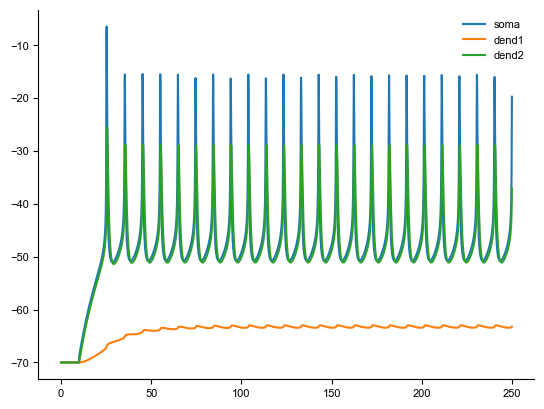

In [22]:
soma.gnabar_hh2 = 0.003*100
soma.gkbar_hh2 = 0.005*150

run_and_plot()

Here, we add a `NetCon` object that will monitor the membrane potential of the cell and detect events with `v` crossing -20 mV. Since this `NetCon` does not need to deliver events to anything else, we connect it to `None`. Then, we can record the event times to a vector, which lets us to record spike times, detected by a voltage threshold.

In [25]:
nc = h.NetCon(soma(0.5)._ref_v, None, -20, 0, 1)
tspike = h.Vector()
nc.record(tspike)

0.0

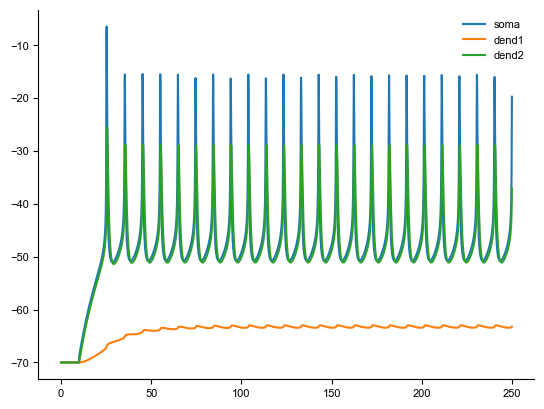

In [26]:
run_and_plot()

Here we print the spike times. Note that we used `.as_numpy` to transform a NEURON `Vector` to a numpy array

In [27]:
print(tspike.as_numpy())

[ 25.125  35.25   45.125  54.9    64.675  74.45   84.2    93.95  103.7
 113.45  123.2   132.95  142.7   152.425 162.175 171.925 181.675 191.425
 201.175 210.925 220.675 230.425 240.15  249.9  ]


## Pyramidal cell example

Now let's simulate the fully active pyramidal cell model. **Please make sure that you restart the kernel at this point.**

In [1]:
import neuron
from neuron import h, gui
import libcell

import numpy as np
import matplotlib.pyplot as plt

First we defined a passive cell,

In [2]:
cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


In [3]:
neuron.load_mechanisms(".")

NEURON: The user defined name already exists: it
 near line 0
 ^
        nrn_load_dll("./x86_64/....")


RuntimeError: hocobj_call error

And then, we call a function in `libcell.py` to embed active mechanisms everywhere,`

In [4]:
libcell.init_active(cell, axon=True, soma=True, dend=True, dendNa=True, dendCa=True)
h.psection()

soma { nseg=7  L=9.26604  Ra=100
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=29.7838}
	insert pas { g_pas=0.000142857 e_pas=-75}
	insert na { gbar_na=1000}
	insert na_ion { ena=60}
	insert kv { gbar_kv=100}
	insert km { gbar_km=2.2}
	insert kca { gbar_kca=3}
	insert k_ion { ek=-90}
	insert ca { gbar_ca=0.5}
	insert it { gbar_it=0.0003}
	insert ca_ion { cai=5e-05 cao=2}
}


1.0

To test the excitability of the cell, we add a current clamp electrode at soma,

In [5]:
ic = h.IClamp(cell.soma(0.5))

Let's define a function to do a virtual current clamp experiment,

In [6]:
def do_current_clamp(current_injected):
    
    # should not forget setting the temperature...
    h.celsius = 35
    
    # Simulation length = 300 ms
    h.tstop = 300

    # Current injection for 200 ms
    ic.delay = 50
    ic.dur = 200
    ic.amp = current_injected


    dt_rec = 0.1
    t = h.Vector()
    v = h.Vector()
    v.record(cell.soma(1)._ref_v, dt_rec)
    t.record(h._ref_t, dt_rec)

    # We set the initial voltage to -75 mV and run the simulation
    h.v_init = -75
    h.init()
    h.run()
    
    # Here we plot the result
    _, ax = plt.subplots()

    ax.plot(t, v)
    ax.set(xlabel="time (ms)", ylabel = "v (mv)")

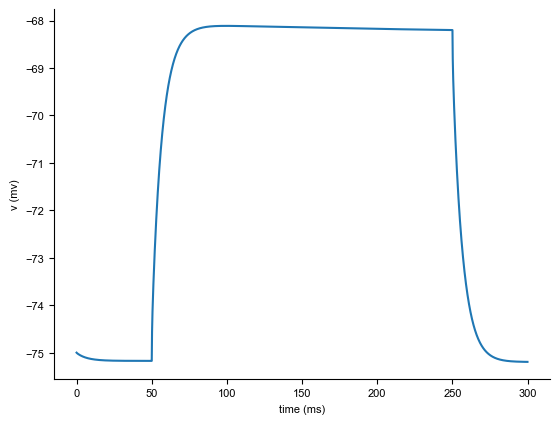

In [7]:
do_current_clamp(0.1) # 100 pA injection; the cell is still in a subthreshold regime

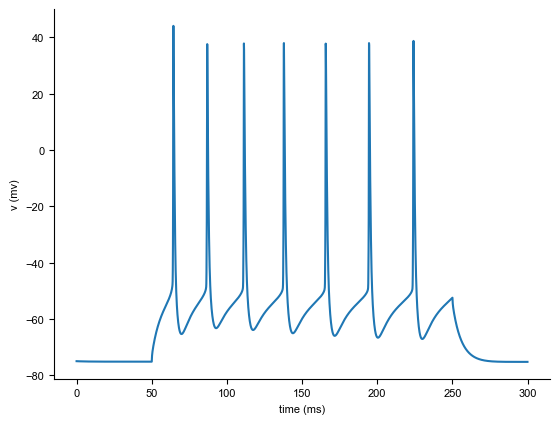

In [8]:
do_current_clamp(0.35) # 350 pA injection will give you spikes